In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from skimage import exposure

import mlflow # model runs
mlflow.set_tracking_uri("sqlite:///mlflow.db") # Use sqlite for more efficient storage
# https://www.mlflow.org/docs/latest/python_api/mlflow.tensorflow.html#mlflow.tensorflow.autolog
mlflow.tensorflow.autolog()

BATCH_SIZE = 128
EQUALIZE = False

mixed_precision.set_global_policy('mixed_float16')


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

2022-06-13 09:30:39.901634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 09:30:39.940388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 09:30:39.940591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-06-13 09:30:40.498910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                  5797
Morula                 1643
2pn                    1519
2 Cell                 1008
Syngamy                 834
4 Cell                  792
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
3 Cell                  373
6 Cell                  360
Early blast             291
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

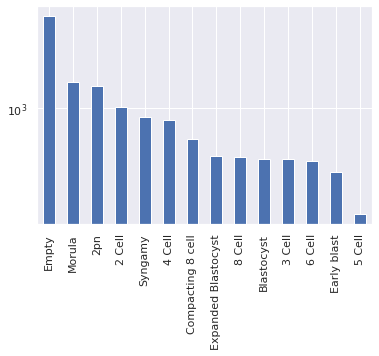

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: "_".join(s.split("/")[-1].split("_")[:2])).value_counts()

M0776_S00512    1952
M776_S0087      1559
M0776_S00635    1294
M0776_S00761    1138
M0776_S00534    1102
M0776_S00470     784
M0831_S00470     229
M0776_S00737     210
M0831_S00659     169
M3169_S00668     138
M3169_S00737      76
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
755                 2pn             1061
685             Syngamy             1464
414              2 Cell             1574
147              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1463             Morula             4286
50          Early blast             6090
113          Blastocyst             6261
4850              Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Early blast',
 'Blastocyst',
 'Empty']

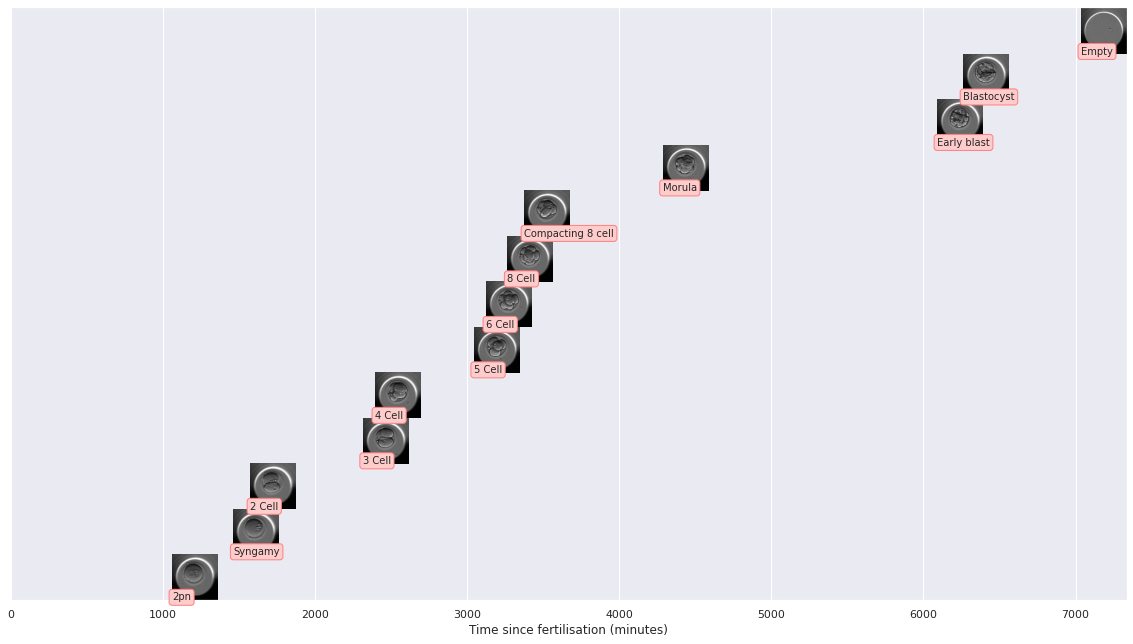

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

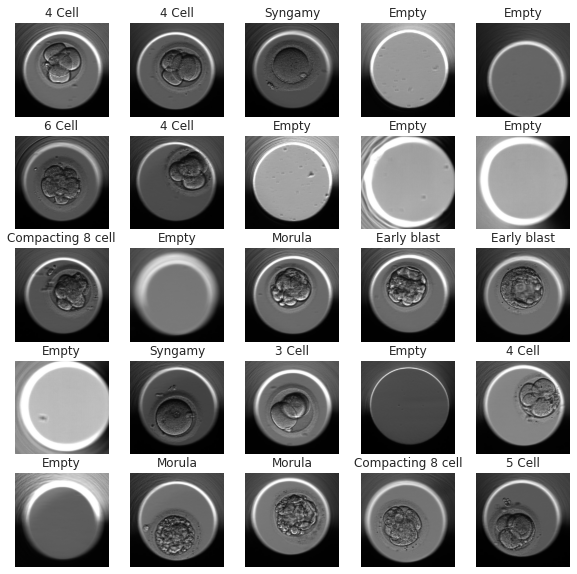

In [7]:
plt.figure(figsize=(10, 10))
sample = df.sample(25)
for i, (idx, row) in enumerate(sample.iterrows()):
    ax = plt.subplot(5, 5, i + 1)
    img = keras.utils.load_img(row.filename, target_size=(299,299))
    if EQUALIZE:
        img = tfa.image.equalize(img)
    plt.imshow(img)
    plt.title(row["class"])
    plt.axis("off")

In [8]:
train = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE, #// 4, # / 4 here, because the augmentations will * 4
    label_mode = 'categorical',
    shuffle = False
)
if EQUALIZE:
    train_cache = train.map(lambda x, y: (tfa.image.equalize(x), y)).cache().prefetch(tf.data.AUTOTUNE)
else:
    train_cache = train.cache().prefetch(tf.data.AUTOTUNE)

Found 14456 files belonging to 14 classes.


2022-06-13 09:30:44.155986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 09:30:44.156765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 09:30:44.156974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 09:30:44.157132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
len(train_cache)

113

In [10]:
list(tqdm(train_cache)); # load it all into RAM

  0%|          | 0/113 [00:00<?, ?it/s]

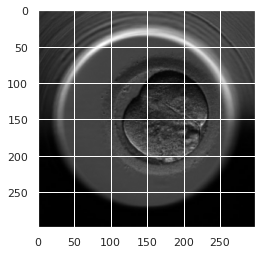

In [11]:
x, y = next(iter(train_cache))
plt.imshow(x.numpy()[0].astype("uint8"))

In [12]:
class AugmentationGenerator(tf.keras.utils.Sequence):
    def __getitem__(self, idx):
        x, y = next(iter(train_cache.skip(idx).take(1)))
        x = np.vstack([
            x,
            np.flip(x, axis=1),
            np.flip(x, axis=2),
            np.flip(np.flip(x, axis=1), axis=2),
        ])
        y = np.vstack([
            y, y, y, y
        ])
        return x, y
    def __len__(self):
        return len(train_cache)

x, y = AugmentationGenerator().__getitem__(0)
print(x.shape, y.shape)

(512, 299, 299, 3) (512, 14)


In [13]:
len(AugmentationGenerator())

113

In [14]:
classes = train.class_names
classes

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [15]:
base_model = keras.Sequential([
    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    keras.layers.Rescaling(scale=1./127.5, offset=-1, input_shape=(299,299,3)),
    keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        include_top=False,
        pooling="avg"
    )
])
base_model.save(f"models/xception.h5")
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


In [37]:
cachefile = f"extracted_features{'_eq' if EQUALIZE else ''}.npy"
print(cachefile)
try:
    extracted_features = np.load(cachefile)
    assert len(extracted_features) == len(train.file_paths)*4
except Exception as e:
    print(e)
    extracted_features = base_model.predict(AugmentationGenerator())
    np.save(cachefile, extracted_features)

extracted_features.npy


In [17]:
extracted_features.shape

(57824, 2048)

In [18]:
y = np.vstack([np.vstack([y,y,y,y]) for x,y in train])
y.shape

(57824, 14)

In [19]:
aug_paths = []
for i in range(len(train)):
    batch_paths = train.file_paths[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    aug_paths.extend(batch_paths * 4)
aug_paths = pd.Series(aug_paths)
aug_paths

0        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1894.jpg
1        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1914.jpg
2        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1934.jpg
3        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1954.jpg
4        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1974.jpg
                                       ...                               
57819     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1555.jpg
57820     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1585.jpg
57821     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1605.jpg
57822     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1625.jpg
57823     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1645.jpg
Length: 57824, dtype: object

In [20]:
#x_train, x_test, y_train, y_test = train_test_split(extracted_features, y, test_size=.2)

# Use one slide for test, everything else for train
test_slide = "M0776_S00512"
test_idx = aug_paths.str.contains(test_slide)
x_train = extracted_features[~test_idx]
y_train = y[~test_idx]
x_test = extracted_features[test_idx]
y_test = y[test_idx]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((48676, 2048), (48676, 14), (9148, 2048), (9148, 14))

In [21]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))
class_weights = class_weights.round(6) # This is necessary if using mlflow, as it can go beyond the 250 character limit otherwise
class_weights = dict(enumerate(class_weights))
{k:v for k,v in zip(classes, class_weights.values())}

{'2 Cell': 1.024376,
 '2pn': 0.676209,
 '3 Cell': 2.768288,
 '4 Cell': 1.303752,
 '5 Cell': 7.942857,
 '6 Cell': 2.868254,
 '8 Cell': 2.688988,
 'Blastocyst': 2.760886,
 'Compacting 8 cell': 1.880822,
 'Early blast': 3.548355,
 'Empty': 0.178122,
 'Expanded Blastocyst': 2.62074,
 'Morula': 0.628467,
 'Syngamy': 1.238095}

In [22]:
%%time
with mlflow.start_run():
    mlflow.log_params({
        "classes": classes,
        "equalized": EQUALIZE,
        "test slide": test_slide,
        "x_train_shape": x_train.shape,
        "y_train_shape": y_train.shape,
        "x_test_shape": x_test.shape,
        "y_test_shape": y_test.shape
    })

    model = keras.Sequential([
        keras.layers.Input(shape=(2048)),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(len(classes), activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.ExponentialDecay(
            .001,
            decay_steps=1e4,
            decay_rate=0.96,
            staircase=True
        )),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    print(model.summary())
    history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        validation_data=(x_test, y_test),
                        epochs=500,
                        verbose=0,
                        class_weight=class_weights,
                        callbacks=[
                            keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=1),
                            tfa.callbacks.TQDMProgressBar()
                        ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 14)                7182      
                                                                 
Total params: 1,318,926
Trainable params: 1,318,926
Non-trainable params: 0
_________________________________________________________________
None


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/381           ETA: ?s - 

Epoch 2/500


0/381           ETA: ?s - 

Epoch 3/500


0/381           ETA: ?s - 

Epoch 4/500


0/381           ETA: ?s - 

Epoch 5/500


0/381           ETA: ?s - 

Epoch 6/500


0/381           ETA: ?s - 

Epoch 7/500


0/381           ETA: ?s - 

Epoch 8/500


0/381           ETA: ?s - 

Epoch 9/500


0/381           ETA: ?s - 

Epoch 10/500


0/381           ETA: ?s - 

Epoch 11/500


0/381           ETA: ?s - 

Epoch 12/500


0/381           ETA: ?s - 

Epoch 13/500


0/381           ETA: ?s - 

Epoch 14/500


0/381           ETA: ?s - 

Epoch 15/500


0/381           ETA: ?s - 

Epoch 16/500


0/381           ETA: ?s - 

Epoch 17/500


0/381           ETA: ?s - 

Epoch 18/500


0/381           ETA: ?s - 

Epoch 19/500


0/381           ETA: ?s - 

Epoch 20/500


0/381           ETA: ?s - 

Epoch 21/500


0/381           ETA: ?s - 

Epoch 22/500


0/381           ETA: ?s - 

Epoch 23/500


0/381           ETA: ?s - 

Epoch 24/500


0/381           ETA: ?s - 

Epoch 25/500


0/381           ETA: ?s - 

Epoch 26/500


0/381           ETA: ?s - 

Epoch 27/500


0/381           ETA: ?s - 

Epoch 28/500


0/381           ETA: ?s - 

Epoch 29/500


0/381           ETA: ?s - 

Epoch 30/500


0/381           ETA: ?s - 

Epoch 31/500


0/381           ETA: ?s - 

Epoch 32/500


0/381           ETA: ?s - 

Epoch 33/500


0/381           ETA: ?s - 

Epoch 34/500


0/381           ETA: ?s - 

Epoch 35/500


0/381           ETA: ?s - 

Epoch 36/500


0/381           ETA: ?s - 

Epoch 37/500


0/381           ETA: ?s - 

Epoch 38/500


0/381           ETA: ?s - 

Epoch 39/500


0/381           ETA: ?s - 

Epoch 40/500


0/381           ETA: ?s - 

Epoch 41/500


0/381           ETA: ?s - 

Epoch 42/500


0/381           ETA: ?s - 

Epoch 43/500


0/381           ETA: ?s - 

Epoch 44/500


0/381           ETA: ?s - 

Epoch 45/500


0/381           ETA: ?s - 

Epoch 46/500


0/381           ETA: ?s - 

Epoch 47/500


0/381           ETA: ?s - 

Epoch 48/500


0/381           ETA: ?s - 

Epoch 49/500


0/381           ETA: ?s - 

Epoch 50/500


0/381           ETA: ?s - 

Epoch 51/500


0/381           ETA: ?s - 

Epoch 52/500


0/381           ETA: ?s - 

Epoch 53/500


0/381           ETA: ?s - 

Epoch 54/500


0/381           ETA: ?s - 

Epoch 55/500


0/381           ETA: ?s - 

Epoch 56/500


0/381           ETA: ?s - 

Epoch 57/500


0/381           ETA: ?s - 

Epoch 58/500


0/381           ETA: ?s - 

Epoch 58: early stopping
INFO:tensorflow:Assets written to: /tmp/tmpv6y51egu/model/data/model/assets
CPU times: user 3min 32s, sys: 38.9 s, total: 4min 11s
Wall time: 2min 31s


In [23]:
model.save(f"models/{len(classes)}_class.h5")

<AxesSubplot:>

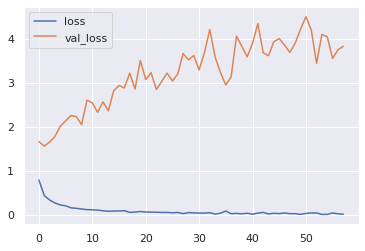

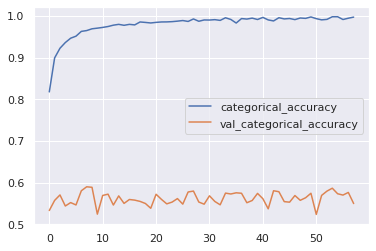

In [24]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [25]:
y_pred = model.predict(x_test)

286/286 [==============================] - 1s 2ms/step


In [26]:
predicted_codes = y_pred.argmax(axis=1)
confidence = y_pred.max(axis=1)
pd.Series(confidence).describe()

count    9148.000000
mean        0.919434
std         0.143311
min         0.258301
25%         0.910522
50%         0.998047
75%         1.000000
max         1.000000
dtype: float64

In [27]:
true_classes = [classes[c] for c in y_test.argmax(axis=1)]
pd.Series(true_classes).value_counts()

Morula                 1520
Empty                  1340
2pn                    1188
Syngamy                 976
4 Cell                  652
2 Cell                  608
8 Cell                  524
Compacting 8 cell       476
Early blast             364
Expanded Blastocyst     356
Blastocyst              348
6 Cell                  312
3 Cell                  260
5 Cell                  224
dtype: int64

In [28]:
validation_df = pd.DataFrame()
validation_df["true_class"] = true_classes
validation_df["predicted_class"] = [classes[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,2 Cell,2 Cell,0.979980
1,2 Cell,2pn,0.592773
2,2 Cell,2 Cell,0.988770
3,2 Cell,4 Cell,0.987793
4,2 Cell,5 Cell,0.999023
...,...,...,...
9143,Syngamy,2pn,0.658691
9144,Syngamy,2pn,0.995117
9145,Syngamy,2pn,0.983887
9146,Syngamy,Syngamy,0.627930


In [29]:
validation_df.groupby("predicted_class").confidence.median()

predicted_class
2 Cell                 0.983887
2pn                    1.000000
3 Cell                 0.907227
4 Cell                 0.990234
5 Cell                 0.780273
6 Cell                 0.971680
8 Cell                 0.919434
Blastocyst             0.970703
Compacting 8 cell      0.919922
Early blast            0.960449
Empty                  1.000000
Expanded Blastocyst    1.000000
Morula                 0.982910
Syngamy                0.996094
Name: confidence, dtype: float16

In [30]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.43      0.60      0.50       608
                2pn       0.60      0.92      0.73      1188
             3 Cell       0.15      0.12      0.13       260
             4 Cell       0.45      0.28      0.34       652
             5 Cell       0.12      0.04      0.07       224
             6 Cell       0.24      0.44      0.31       312
             8 Cell       0.46      0.18      0.26       524
         Blastocyst       0.43      0.28      0.34       348
  Compacting 8 cell       0.21      0.34      0.26       476
        Early blast       0.34      0.54      0.42       364
              Empty       0.99      1.00      1.00      1340
Expanded Blastocyst       0.53      0.93      0.68       356
             Morula       0.67      0.41      0.51      1520
            Syngamy       0.75      0.37      0.50       976

           accuracy                           0.55      9148
          macro avg   

Text(66.5, 0.5, 'True')

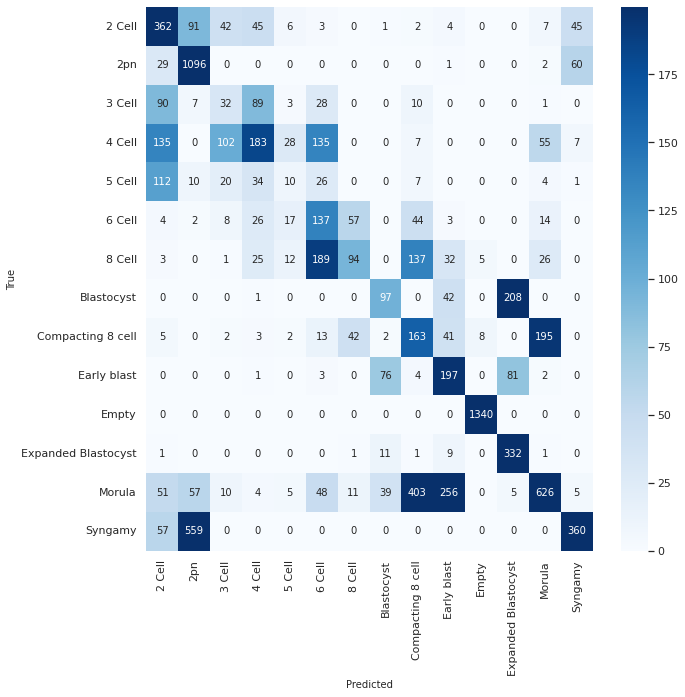

In [31]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
confusion = confusion_matrix(validation_df["true_class"], validation_df["predicted_class"])
print(np.quantile(confusion, np.arange(0, 1, .1)))
plt.figure(figsize=(10,10))
s = sns.heatmap(
    confusion,
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes,
    vmax=np.quantile(confusion, .95)
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)